In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../../py_utils':
    sys.path.insert(0,'../../py_utils')

import file_utils  
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
summary_team_file = '../../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../../Data/D1_teams.csv'
tournament_data_file = '../../Data/tournament_results_2018.csv'
rankings_data_file = '../../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
# Do not use 2018 data for training
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [4]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [5]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor


In [6]:
# dropping delta_rpi
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_mor']

for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)

#scaler =StandardScaler()
#tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
#tourney_comp_ratings.head()

In [7]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']

In [8]:
feature_data = tourney_comp_ratings[feature_columns].copy()
#feature_data

#### Setup feature columns for Tensorflow

In [9]:
tf_top_conf_t = tf.feature_column.numeric_column('top_conf_t')
tf_top_conf_o = tf.feature_column.numeric_column('top_conf_o')
tf_margin_victory = tf.feature_column.numeric_column('delta_margin_victory_avg')
tf_delta_fg = tf.feature_column.numeric_column('delta_fg_pct')
tf_delta_off_rebs = tf.feature_column.numeric_column('delta_off_rebs_avg')
tf_delta_def_rebs = tf.feature_column.numeric_column('delta_def_rebs_avg')
tf_delta_ft = tf.feature_column.numeric_column('delta_ft_pct')
tf_delta_to = tf.feature_column.numeric_column('delta_to_net_avg')
tf_delta_win = tf.feature_column.numeric_column('delta_win_pct')
tf_delta_off_rating = tf.feature_column.numeric_column('delta_off_rating')
tf_delta_ft_att = tf.feature_column.numeric_column('delta_ft_att_avg')
tf_delta_seed = tf.feature_column.numeric_column('delta_seed')
tf_delta_srs = tf.feature_column.numeric_column('delta_srs')
tf_delta_sos = tf.feature_column.numeric_column('delta_sos')
tf_delta_sag = tf.feature_column.numeric_column('delta_sag')
tf_delta_wlk = tf.feature_column.numeric_column('delta_wlk')
tf_delta_wol = tf.feature_column.numeric_column('delta_wol')
tf_delta_rth = tf.feature_column.numeric_column('delta_rth')
tf_delta_col = tf.feature_column.numeric_column('delta_col')
tf_delta_pom = tf.feature_column.numeric_column('delta_pom')
tf_delta_dol = tf.feature_column.numeric_column('delta_dol')
#tf_delta_rpi = tf.feature_column.numeric_column('delta_rpi')
tf_delta_mor = tf.feature_column.numeric_column('delta_mor')

# todo  drop tf_delta_rpi
tf_feat_cols = [tf_margin_victory, tf_delta_fg, tf_delta_off_rebs, 
                tf_delta_def_rebs, tf_delta_ft, tf_delta_to, tf_delta_win, tf_delta_off_rating, 
                tf_delta_ft_att, tf_delta_seed, tf_delta_srs, tf_delta_sos, tf_delta_sag, 
                tf_delta_wlk, tf_delta_wol, tf_delta_rth, tf_delta_col, tf_delta_pom,
                tf_delta_dol, tf_delta_mor]

In [10]:
X= feature_data[feature_data['season_t']<= stop_tournament]
tourney_comp_ratings['label'] = tourney_comp_ratings.apply(lambda x: 0 if x.game_result==-1 else 1, axis=1)
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['label']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 22)
(782,)
(196, 22)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3.0,-10.13,-6.65,97.0,106.0,98.0,94.0,88.0,80.0,103.0,102.0,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7.0,5.32,-3.24,-24.0,-33.0,-25.0,-25.0,-28.0,-24.0,-30.0,-19.0,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3.0,4.23,0.00,-11.0,-11.0,-15.0,-13.0,-14.0,-12.0,-18.0,-14.0,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0.0,-1.24,0.41,8.0,1.0,3.0,2.0,-4.0,-16.0,12.0,-7.0,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11.0,12.38,11.36,-64.0,-66.0,-58.0,-98.0,-79.0,-56.0,-78.0,-73.0,1,0


In [12]:
scaler =StandardScaler(copy=True, with_mean=True, with_std=True)

scaler.fit(X_train[numeric_features])
X_train[numeric_features]
scaler.fit_transform(X_test[numeric_features])

array([[-8.48958839e-02, -1.15511934e-01, -1.87207263e+00, ...,
         1.71106288e-01, -4.61116808e-02, -8.35901844e-02],
       [-1.08327148e+00,  7.88761966e-01,  3.72124530e-01, ...,
         4.29302603e-01,  4.22519623e-01,  1.35223520e-01],
       [ 2.47895981e-01,  5.19461953e-02, -3.75941192e-01, ...,
        -1.44466986e-01, -2.97164165e-01, -1.65645324e-01],
       ...,
       [ 5.80687846e-01, -6.84869575e-01, -1.90833092e-03, ...,
        -1.02458855e-03,  2.08356483e-02,  2.58166680e-02],
       [ 4.14291913e-01,  5.87812210e-01, -3.75941192e-01, ...,
        -3.16597862e-01, -9.63221776e-02, -1.92997037e-01],
       [ 1.07987564e+00,  5.20828959e-01, -3.75941192e-01, ...,
        -5.17417218e-01, -6.31900811e-01, -2.61376319e-01]])

#### Baseline Model

In [13]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=50, num_epochs=None, shuffle=True )

In [14]:
model = tf.estimator.LinearClassifier(feature_columns= tf_feat_cols, n_classes=2)
model.train(input_fn = input_func, steps=15000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\CHIPK\\AppData\\Local\\Temp\\tmpg0ud__om', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FFA3A34CC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 int

INFO:tensorflow:global_step/sec: 470.741
INFO:tensorflow:loss = 17.74307, step = 7201 (0.212 sec)
INFO:tensorflow:global_step/sec: 464.13
INFO:tensorflow:loss = 18.55235, step = 7301 (0.217 sec)
INFO:tensorflow:global_step/sec: 464.269
INFO:tensorflow:loss = 18.776573, step = 7401 (0.214 sec)
INFO:tensorflow:global_step/sec: 464.204
INFO:tensorflow:loss = 17.529438, step = 7501 (0.215 sec)
INFO:tensorflow:global_step/sec: 462.06
INFO:tensorflow:loss = 16.280159, step = 7601 (0.215 sec)
INFO:tensorflow:global_step/sec: 447.623
INFO:tensorflow:loss = 17.109035, step = 7701 (0.223 sec)
INFO:tensorflow:global_step/sec: 464.134
INFO:tensorflow:loss = 19.667173, step = 7801 (0.216 sec)
INFO:tensorflow:global_step/sec: 457.907
INFO:tensorflow:loss = 22.316422, step = 7901 (0.218 sec)
INFO:tensorflow:global_step/sec: 457.841
INFO:tensorflow:loss = 21.729998, step = 8001 (0.217 sec)
INFO:tensorflow:global_step/sec: 459.876
INFO:tensorflow:loss = 17.917452, step = 8101 (0.218 sec)
INFO:tensorflo

In [15]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test, batch_size=50, num_epochs=1, shuffle=False)

In [16]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-15-18:31:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpg0ud__om\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-15-18:31:10
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.7397959, accuracy_baseline = 0.54591835, auc = 0.82621026, auc_precision_recall = 0.83893454, average_loss = 0.56356853, global_step = 15000, label/mean = 0.54591835, loss = 27.614859, precision = 0.7641509, prediction/mean = 0.5475678, recall = 0.7570093
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: C:\Users\CHIPK\AppData\Local\Temp\tmpg0ud__om\model.ckpt-15000


{'accuracy': 0.7397959,
 'accuracy_baseline': 0.54591835,
 'auc': 0.82621026,
 'auc_precision_recall': 0.83893454,
 'average_loss': 0.56356853,
 'label/mean': 0.54591835,
 'loss': 27.614859,
 'precision': 0.7641509,
 'prediction/mean': 0.5475678,
 'recall': 0.7570093,
 'global_step': 15000}

#### Identify the predicted results for the test samples

In [17]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, batch_size=50, num_epochs=1, shuffle=False)
predictions_test = model.predict(pred_input_func)
test_predictions = list(predictions_test)
test_predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpg0ud__om\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([1.6231055], dtype=float32),
  'logistic': array([0.83522296], dtype=float32),
  'probabilities': array([0.16477703, 0.83522296], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.7199382], dtype=float32),
  'logistic': array([0.6725934], dtype=float32),
  'probabilities': array([0.3274066, 0.6725934], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([3.0096226], dtype=float32),
  'logistic': array([0.9530069], dtype=float32),
  'probabilities': array([0.04699304, 0.9530069 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([1.5782273], dtype=float32),
  'logistic': array([0.8289533], dtype=float32),
  'probabilities': array([0.17104669, 0.8289533 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array

In [18]:
test_preds = [pred['class_ids'][0] for pred in test_predictions ]

In [19]:
y_test_df = y_test.to_frame('y_actual')
y_test_df['y_predict'] = test_preds


In [20]:
missed_predictions = y_test_df[y_test_df['y_actual'] != y_test_df['y_predict']].copy()
missed_predictions.reset_index(inplace=True)
missed_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_predictions = missed_predictions.sort_values(by=['sample_index'])
len(missed_predictions.index)

51

array([[64, 25],
       [26, 81]], dtype=int64)

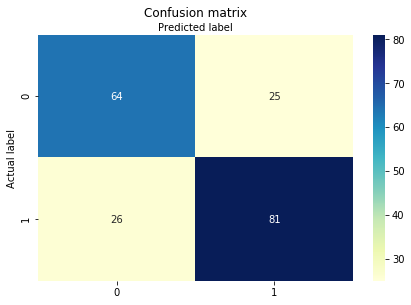

In [21]:
utils.display_confusion_matrix(y_test, test_preds)

#### Predict 2018

In [28]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
X_season = X_season.copy()
X_season[numeric_features]=scaler.transform(X_season[numeric_features])
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['label']
X_season.shape

(67, 23)

In [29]:
pred_2018_input_func = tf.estimator.inputs.pandas_input_fn(x=X_season, batch_size=10, num_epochs=1, shuffle=False)
predictions_2018 = model.predict(pred_2018_input_func)
pred_2018 = list(predictions_2018)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmpg0ud__om\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [30]:
preds_2018 = [pred['class_ids'][0] for pred in pred_2018 ]
y_2018_df = y_season.to_frame('y_actual')
y_2018_df['y_predict'] = preds_2018
y_2018_df.head()

,y_actual,y_predict
981,1,1
982,0,0
983,1,0
984,0,0
985,1,0


In [31]:
t1_win_probabilities = [pred['probabilities'][1] for pred in pred_2018 ]
#t1_win_probabilities

In [32]:
missed_2018_predictions = y_2018_df[y_2018_df['y_actual'] != y_2018_df['y_predict']].copy()

missed_2018_predictions.reset_index(inplace=True)
missed_2018_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_2018_predictions = missed_2018_predictions.sort_values(by=['sample_index'])
#len(missed_2018_predictions.index)
missed_2018_predictions

,sample_index,y_actual,y_predict
0,983,1,0
1,985,1,0
2,988,0,1
3,997,1,0
4,1003,1,0
5,1004,0,1
6,1005,1,0
7,1006,0,1
8,1007,1,0
9,1008,0,1


array([[24,  9],
       [13, 21]], dtype=int64)

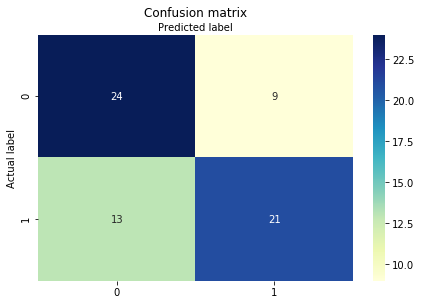

In [33]:
utils.display_confusion_matrix(y_season, preds_2018)

#### Counter Seeding Predictions

In [ ]:
def map_zero_to_minus_one(x):
    if x==0:
        return -1
    else:
        return x
    

In [ ]:
tourney_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_season.index)].copy()
tourney_games['predicted'] = preds_2018
tourney_games.predicted = tourney_games['predicted'].apply(lambda x: map_zero_to_minus_one(x))
tourney_games.head()

In [ ]:
cond_1 = (tourney_games['seed_t'] > tourney_games['seed_o']) & (tourney_games['predicted'] == 1)
cond_2 = (tourney_games['seed_t'] < tourney_games['seed_o']) & (tourney_games['predicted'] == -1)

predictions_counter_seed = tourney_games[cond_1 | cond_2]
predictions_counter_seed[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

In [ ]:
# correct counter seed predictions
correct_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result']== predictions_counter_seed['predicted']]
correct_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

In [ ]:
# incorrect counter seed predictions
wrong_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result'] != predictions_counter_seed['predicted']]
wrong_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

In [ ]:
print("Number of counter seed predictions= ", len(predictions_counter_seed.index))
print("Number of correct counter seed predictions= ", len(correct_counter_predictions.index))

In [ ]:
log_loss_result = utils.compute_log_loss(tourney_games['game_result'].values, np.array(t1_win_probabilities))
log_loss_result